# DCGAN on the MNIST Dataset

In [1]:
import tempfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import fastestimator as fe
from fastestimator.backend import binary_crossentropy, feed_forward
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop import LambdaOp
from fastestimator.op.numpyop.univariate import ExpandDims, Normalize
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import ModelSaver

In [2]:
batch_size = 256
epochs = 50
train_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
model_name = 'model_epoch_50.h5'

<h2>Building components</h2>

### Step 1: Prepare training and define a `Pipeline`

We are loading data from tf.keras.datasets.mnist and defining a series of operations to perform on the data before the training:

In [3]:
train_data, _ = mnist.load_data()
pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x"),
        Normalize(inputs="x", outputs="x", mean=1.0, std=1.0, max_pixel_value=127.5),
        LambdaOp(fn=lambda: np.random.normal(size=[100]).astype('float32'), outputs="z")
    ])

### Step 2: Create a `model` and FastEstimator `Network`

First, we have to define the network architecture for both our <b>Generator</b> and <b>Discriminator</b>. After defining the architecture, users are expected to feed the architecture definition, along with associated model names and optimizers, to fe.build.

In [4]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [5]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
gen_model = fe.build(model_fn=generator, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))
disc_model = fe.build(model_fn=discriminator, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))

2022-05-17 22:24:12.679107: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 22:24:13.365903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32253 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


We define the generator and discriminator losses. These can have multiple inputs and outputs.

In [7]:
class GLoss(TensorOp):
    """Compute generator loss."""
    def forward(self, data, state):
        return binary_crossentropy(y_pred=data, y_true=tf.ones_like(data), from_logits=True)

In [8]:
class DLoss(TensorOp):
    """Compute discriminator loss."""
    def forward(self, data, state):
        true_score, fake_score = data
        real_loss = binary_crossentropy(y_pred=true_score, y_true=tf.ones_like(true_score), from_logits=True)
        fake_loss = binary_crossentropy(y_pred=fake_score, y_true=tf.zeros_like(fake_score), from_logits=True)
        total_loss = real_loss + fake_loss
        return total_loss

`fe.Network` takes series of operators. Here we pass our models wrapped into `ModelOps` along with our loss functions and some update rules:

In [9]:
network = fe.Network(ops=[
        ModelOp(model=gen_model, inputs="z", outputs="x_fake"),
        ModelOp(model=disc_model, inputs="x_fake", outputs="fake_score"),
        GLoss(inputs="fake_score", outputs="gloss"),
        UpdateOp(model=gen_model, loss_name="gloss"),
        ModelOp(inputs="x", model=disc_model, outputs="true_score"),
        DLoss(inputs=("true_score", "fake_score"), outputs="dloss"),
        UpdateOp(model=disc_model, loss_name="dloss")
    ])

2022-05-17 22:24:13.980469: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Step 3: Prepare `Estimator` and configure the training loop

We will define an `Estimator` that has four notable arguments: network, pipeline, epochs and traces. Our `Network` and `Pipeline` objects are passed here as an argument along with the number of epochs and a `Trace`, in this case one designed to save our model every 5 epochs.

In [10]:
traces=ModelSaver(model=gen_model, save_dir=save_dir, frequency=5)

In [11]:
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch)

<h2>Training</h2>

In [12]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: the key 'y' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.


2022-05-17 22:24:19.148391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-17 22:24:19.882754: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; dloss: 1.4074755; gloss: 0.6938505;
FastEstimator-Train: step: 100; dloss: 1.071872; gloss: 0.6625423; steps/sec: 96.76;
FastEstimator-Train: step: 200; dloss: 1.1390224; gloss: 0.7711286; steps/sec: 153.13;
FastEstimator-Train: step: 235; epoch: 1; epoch_time: 6.54 sec;
FastEstimator-Train: step: 300; dloss: 1.1058098; gloss: 0.8283564; steps/sec: 21.38;
FastEstimator-Train: step: 400; dloss: 1.2330828; gloss: 0.8234701; steps/sec: 137.98;
FastEstimator-Train: step: 470; epoch: 2; epoch_time: 4.88 sec;
FastEstimator-Train: step: 500; dloss: 1.0860771; gloss: 0.8769846; steps/sec: 26.53;
FastEstimator-Train: step: 600; dloss: 1.3000612; gloss: 0.76368; steps/sec: 139.42;
FastEstimator-Train: step: 700; dloss: 1.3079492; gloss: 0.7894113; steps/sec: 136.25;
FastEstimator-Train: step: 705; epoch: 3; epoch_time: 4.73 sec;
FastEstimator-Train: step: 800; dloss: 0.95769334; gloss: 1.0632424; st

FastEstimator-Train: step: 6815; epoch: 29; epoch_time: 6.77 sec;
FastEstimator-Train: step: 6900; dloss: 0.99310243; gloss: 1.0726111; steps/sec: 19.46;
FastEstimator-Train: step: 7000; dloss: 1.3016744; gloss: 1.1302423; steps/sec: 80.95;
FastEstimator-ModelSaver: Saved model to /tmp/tmp7hg1f143/model_epoch_30.h5
FastEstimator-Train: step: 7050; epoch: 30; epoch_time: 6.59 sec;
FastEstimator-Train: step: 7100; dloss: 1.1211019; gloss: 1.0915082; steps/sec: 22.69;
FastEstimator-Train: step: 7200; dloss: 1.0433137; gloss: 1.3584124; steps/sec: 74.73;
FastEstimator-Train: step: 7285; epoch: 31; epoch_time: 6.6 sec;
FastEstimator-Train: step: 7300; dloss: 1.3104564; gloss: 1.133613; steps/sec: 18.21;
FastEstimator-Train: step: 7400; dloss: 1.195024; gloss: 1.1311966; steps/sec: 82.59;
FastEstimator-Train: step: 7500; dloss: 1.1094584; gloss: 1.1424885; steps/sec: 84.76;
FastEstimator-Train: step: 7520; epoch: 32; epoch_time: 6.99 sec;
FastEstimator-Train: step: 7600; dloss: 0.9371455; gl

<h2>Inferencing</h2>

For inferencing, first we have to load the trained model weights. We will load the trained generator weights using <i>fe.build</i>

In [13]:
model_path = os.path.join(save_dir, model_name)
trained_model = fe.build(model_fn=generator, weights_path=model_path, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))

We will the generate some images from random noise:

In [14]:
images = feed_forward(trained_model, np.random.normal(size=(16, 100)), training=False)

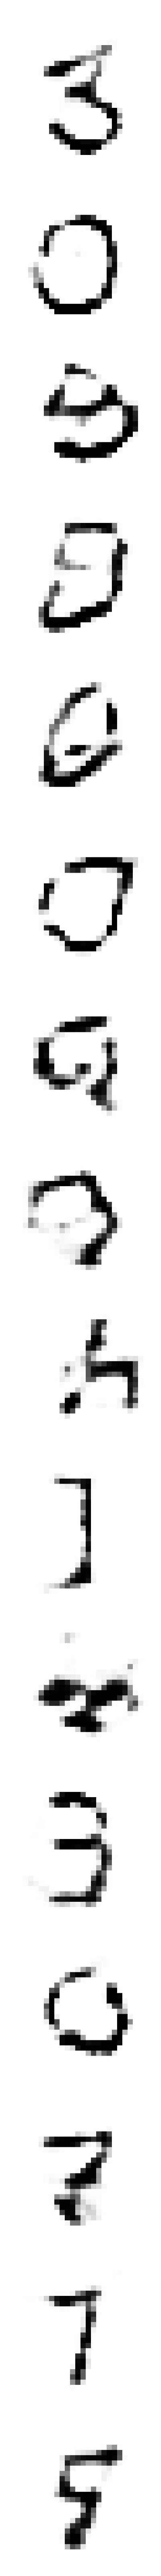

In [15]:
fe.util.BatchDisplay(image=images).show()